In [1]:
# This filters any outputs from libraries that we don't want to see, and clear_output removes any outputs generated by a cell
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
clear_output()

In [2]:
import numpy as np
import pandas as pd

# Visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno #For missing value visualization
#from wordcloud import WordCloud

# From here: https://www.tutorialspoint.com/plotly/plotly_plotting_inline_with_jupyter_notebook.htm
import plotly.offline as py
py.init_notebook_mode(connected=True)

# library for loading
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

import time
import datetime

In [3]:
# matching strings via regex expressions
import re

# string utility
import string

# main nlp library and modell
import spacy
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")
clear_output()

In [4]:
# Calculation of Performance of Models
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score

In [5]:
# Regression model
from sklearn.linear_model import LogisticRegression

# Ensemble model
from sklearn.tree import DecisionTreeClassifier

# Essentially, Random Forest is a group of decision trees
from sklearn.ensemble import RandomForestClassifier

# Support Vector Classifier, based on SVMs (Support Vector Machines)
from sklearn.svm import SVC

# https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html
from sklearn.naive_bayes import MultinomialNB

from sklearn.tree import ExtraTreeClassifier
from sklearn.multiclass import OneVsRestClassifier

# Random classification, ignoring inputs
from sklearn.dummy import DummyClassifier

In [6]:
# loading excel table
data = pd.read_excel(r"C:\Users\Arne Jandt\anaconda3\envs\UebungenProjekt\bmw_cardata_all.xlsx")
data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Arne Jandt\\anaconda3\\envs\\UebungenProjekt\\bmw_cardata_all.xlsx'

In [ ]:
# inspecting data
data.isnull().sum()

In [ ]:
cleaned_data = data.dropna()


In [ ]:
# inspecting data shape
cleaned_data.shape

In [ ]:
# inspecting data
data.nunique()

In [ ]:
# searching for missing data
msno.matrix(cleaned_data)

In [ ]:
# inspecting column values
#cleaned_data['car_gebraucht_oder_new'].unique()
#cleaned_data['car_getriebe'].unique()
cleaned_data['car_kraftstoff'].unique()

In [ ]:
# drop column car_fahrzeughalter and car_verbrauch
cleaned_data = data.drop(['car_fahrzeughalter','car_verbrauch'],axis=1)


# cleaning column car_kilometerstand
# initializing unit 
unit = "km"
  
# Remove Units from Value List
# Using replace() + strip() + list comprehension
cleaned_data["car_kilometerstand"] = [sub.replace(unit, "").strip() for sub in cleaned_data["car_kilometerstand"]]
cleaned_data['car_kilometerstand'] = [sub.replace('.', "").strip() for sub in cleaned_data["car_kilometerstand"]]
cleaned_data['car_kilometerstand'] = pd.to_numeric(cleaned_data['car_kilometerstand'])

# clean column car_co2_ausstross
# initializing unit 
unit = "g/km (komb.)"
  
# Remove Units from Value List
# Using replace() + strip() + list comprehension
cleaned_data["car_co2_ausstoss"] = [sub.replace(unit, "").strip() for sub in cleaned_data["car_co2_ausstoss"]]
cleaned_data["car_co2_ausstoss"] = [sub.replace("- (g/km)", "0").strip() for sub in cleaned_data["car_co2_ausstoss"]]
cleaned_data['car_co2_ausstoss'] = pd.to_numeric(cleaned_data['car_co2_ausstoss'])


#cleaning column erstzulassung
cleaned_data['car_erstzulassung'] = cleaned_data['car_erstzulassung'].replace('- (Erstzulassung)', np.nan)
cleaned_data['car_erstzulassung'] = cleaned_data['car_erstzulassung'].fillna(0)
# https://stackoverflow.com/questions/50863691/pandas-convert-date-object-to-int
# cleaned_data['car_erstzulassung'] = cleaned_data['car_erstzulassung']
# cleaning column 'car_erstzulassung'
cleaned_data['car_erstzulassung'] = pd.to_datetime(cleaned_data['car_erstzulassung'])
cleaned_data['car_erstzulassung'] = cleaned_data['car_erstzulassung'].dt.strftime('%Y%m%d').astype(int)

# cleaning column car_leistung
for i in range(len(cleaned_data)):
    strt_pos = cleaned_data['car_leistung'].values[i].find('(')
    stop_pos = cleaned_data['car_leistung'].values[i].find(')')
    cleaned_data['car_leistung'].values[i] = f"{cleaned_data['car_leistung'].values[i][:strt_pos:].strip()} {cleaned_data['car_leistung'].values[i][stop_pos+1:].strip()}"
cleaned_data['car_leistung'] = cleaned_data['car_leistung'].str.replace(r'\D', '')
cleaned_data['car_leistung'] = pd.to_numeric(cleaned_data['car_leistung'])


# cleaning column 'car_kraftstoff'
cleaned_data['car_kraftstoff'] = cleaned_data['car_kraftstoff'].replace({'Benzin': 1,'Diesel':2,'Elektro/Benzin': 3,'Elektro/Diesel':4,'Sonstige': 5,
                                                                      '- (Kraftstoff)': 0, 'Automatik': 0})
# cleaning column 'car_getriebe'
cleaned_data['car_getriebe'] = cleaned_data['car_getriebe'].replace({'Automatik': 1, 'Schaltgetriebe': 2,'Halbautomatik': 3,  '- (Getriebe)': 0, '1 Fahrzeughalter': 0,})

# cleaning column 'car_gebraucht_oder_new'
cleaned_data['car_gebraucht_oder_new'] = cleaned_data['car_gebraucht_oder_new'].replace({'Gebraucht': 1, 'Neu': 2, 'Vorführfahrzeug': 3, 'Jahreswagen':4, 'Oldtimer': 5,'195 kW (265 PS)':0, '290 kW (394 PS)':0})


# cleaning column 'Price'
cleaned_data['Price'] = [sub.replace('€', "").strip() for sub in cleaned_data['Price']]
cleaned_data['Price'] = [sub.replace(',-', "").strip() for sub in cleaned_data['Price']]
cleaned_data['Price'] = [sub.replace('.', "").strip() for sub in cleaned_data['Price']]
cleaned_data['Price'] = pd.to_numeric(cleaned_data['Price'])



cleaned_data.head()

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')


In [ ]:
def tokenize(column):
    """Tokenizes a Pandas dataframe column and returns a list of tokens.

    Args:
        column: Pandas dataframe column (i.e. df['text']).

    Returns:
        tokens (list): Tokenized list, i.e. [Donald, Trump, tweets]
    """

    tokens = nltk.wordpunct_tokenize(column)
    return [w for w in tokens]    

In [ ]:


cleaned_data['tokenized'] = cleaned_data.apply(lambda x: tokenize(str(x['Version'])), axis=1)
cleaned_data.head()

In [ ]:
# counting tokenized words
# https://stackoverflow.com/questions/55672912/faster-way-to-count-total-occurrences-of-values-in-a-column-of-lists-in-pandas
top_tokenized_words = pd.Series([x for item in cleaned_data['tokenized'] for x in item]).value_counts()
print(top_tokenized_words.head(20))

In [ ]:
# searching for feature M, xDrive, Sport, d, Navi (optimized engine for sport purpose)
#https://stackoverflow.com/questions/45750493/see-if-item-in-each-row-of-pandas-series
cleaned_data = cleaned_data.assign(feature_M = cleaned_data['tokenized'].apply(set) & set(['M']),
                   feature_xDrive = cleaned_data['tokenized'].apply(set) & set(['xDrive']),
                    feature_Sport = cleaned_data['tokenized'].apply(set) & set(['Sport']),
                    feature_d = cleaned_data['tokenized'].apply(set) & set(['d']),
                    feature_Navi = cleaned_data['tokenized'].apply(set) & set(['Navi']))
#cleaned_data.assign(feature_xDrive = cleaned_data['tokenized'].apply(set) & set(['xDrive']))
#cleaned_data.assign(feature_Sport = cleaned_data['tokenized'].apply(set) & set(['Sport']))
#cleaned_data.assign(feature_d = cleaned_data['tokenized'].apply(set) & set(['d']))
#cleaned_data.assign(feature_Navi = cleaned_data['tokenized'].apply(set) & set(['Navi']))
#cleaned_data.to_excel("output_data_4.xlsx",index=False)


In [ ]:
# replace True or False with 0 and 1
cleaned_data['feature_M'] = cleaned_data['feature_M'].replace({False:0,True:1})
cleaned_data['feature_xDrive'] = cleaned_data['feature_xDrive'].replace({False:0,True:1})
cleaned_data['feature_Sport'] = cleaned_data['feature_Sport'].replace({False:0,True:1})
cleaned_data['feature_d'] = cleaned_data['feature_d'].replace({False:0,True:1})
cleaned_data['feature_Navi'] = cleaned_data['feature_Navi'].replace({False:0,True:1})
cleaned_data.to_excel("output_data_7.xlsx",index=False)

In [ ]:
cleaned_data.head()

In [ ]:
#w='M'
#feature_M = [[any(w==term for w in lst) for term in terms] for lst in cleaned_data['tokenized']]
print(top_tokenized_words.head(20))

In [ ]:
#cleaned_data = cleaned_data.assign(counted_tokens=top_tokenized_words.values)
#combined_data = pd.concat([cleaned_data,top_tokenized_words],axis=1)

In [73]:
data = pd.read_excel(r"C:\Users\Ammar Khidir\Desktop\output_data_7.xlsx")
data.head()

,Version,car_kilometerstand,car_erstzulassung,car_leistung,car_gebraucht_oder_new,car_getriebe,car_kraftstoff,car_co2_ausstoss,tokenized,feature_M,feature_xDrive,feature_Sport,feature_d,feature_Navi,Price
0,xDrive 30e Advantage Steptronic,42092,20200901,215,1,1,3,49,"['xDrive', '30e', 'Advantage', 'Steptronic']",0,1,0,0,0,43490
1,xDrive30i Leder Pano Totwinkel HiFi Kamera Navi,0,19700101,180,2,1,1,175,"['xDrive30i', 'Leder', 'Pano', 'Totwinkel', 'H...",0,0,0,0,1,59510
2,xDrive20d HUD DA+ Pano PA+ Sportsitze AHK,16100,20201101,140,1,1,2,126,"['xDrive20d', 'HUD', 'DA', '+', 'Pano', 'PA', ...",0,0,0,0,0,46490
3,xDrive20i Advatage Aut. Navi PDC RFK AHK LED,56100,20191101,135,1,1,1,151,"['xDrive20i', 'Advatage', 'Aut', '.', 'Navi', ...",0,0,0,0,1,34630
4,xDrive30d M Sport (Gestiksteuerung Head-Up),58417,20190701,195,1,1,2,157,"['xDrive30d', 'M', 'Sport', '(', 'Gestiksteuer...",1,0,1,0,0,44290


In [74]:
newdata = data.drop(['Version','tokenized'],axis='columns')



In [75]:
newdata['car_kilometerstand'] = (newdata['car_kilometerstand'] - newdata['car_kilometerstand'].min()) / (newdata['car_kilometerstand'].max() - newdata['car_kilometerstand'].min())    
newdata['car_erstzulassung'] = (newdata['car_erstzulassung'] - newdata['car_erstzulassung'].min()) / (newdata['car_erstzulassung'].max() - newdata['car_erstzulassung'].min())    
newdata['car_leistung'] = (newdata['car_leistung'] - newdata['car_leistung'].min()) / (newdata['car_leistung'].max() - newdata['car_leistung'].min())    
newdata['car_co2_ausstoss'] = (newdata['car_co2_ausstoss'] - newdata['car_co2_ausstoss'].min()) / (newdata['car_co2_ausstoss'].max() - newdata['car_co2_ausstoss'].min())    
newdata['Price'] = (newdata['Price'] - newdata['Price'].min()) / (newdata['Price'].max() - newdata['Price'].min())    
newdata.head()


,car_kilometerstand,car_erstzulassung,car_leistung,car_gebraucht_oder_new,car_getriebe,car_kraftstoff,car_co2_ausstoss,feature_M,feature_xDrive,feature_Sport,feature_d,feature_Navi,Price
0,0.104706,0.961044,0.281250,1,1,3,0.049049,0,1,0,0,0,0.132930
1,0.000000,0.000000,0.208333,2,1,1,0.175175,0,0,0,0,1,0.182930
2,0.040050,0.961428,0.125000,1,1,2,0.126126,0,0,0,0,0,0.142294
3,0.139552,0.942238,0.114583,1,1,1,0.151151,0,0,0,0,1,0.105277
4,0.145316,0.941470,0.239583,1,1,2,0.157157,1,0,1,0,0,0.135427


In [92]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error as MSE
#Seperatingthe Target variable

X = newdata.drop(['Price'], axis='columns')

Y = newdata['Price']

#SplitingDatasetintoTest and Train 
X_train, X_test, y_train, y_test= train_test_split( X,Y, test_size= 0.2, random_state= 3)
#Function to perform training with Entropy 
#clf_entropy= DecisionTreeClassifier(criterion = "entropy", random_state= 100, max_depth=3, min_samples_leaf=5)
#clf_entropy.fit(X_train, y_train)
#Instantiate a DecisionTreeRegressor 'dt'
dt = DecisionTreeRegressor(max_depth=4,
                          min_samples_leaf=0.1,
                          random_state=3)
#Fit 'dt' to the trainning-set
dt.fit(X_train, y_train)
#Predict test-set lables
y_pred = dt.predict(X_test)
#Compute test-set MSE
mse_dt = MSE(y_test, y_pred)
#Compute test-set RMSE
rmse_dt = mse_dt**(1/2)

print(rmse_dt)


0.058742422420519816


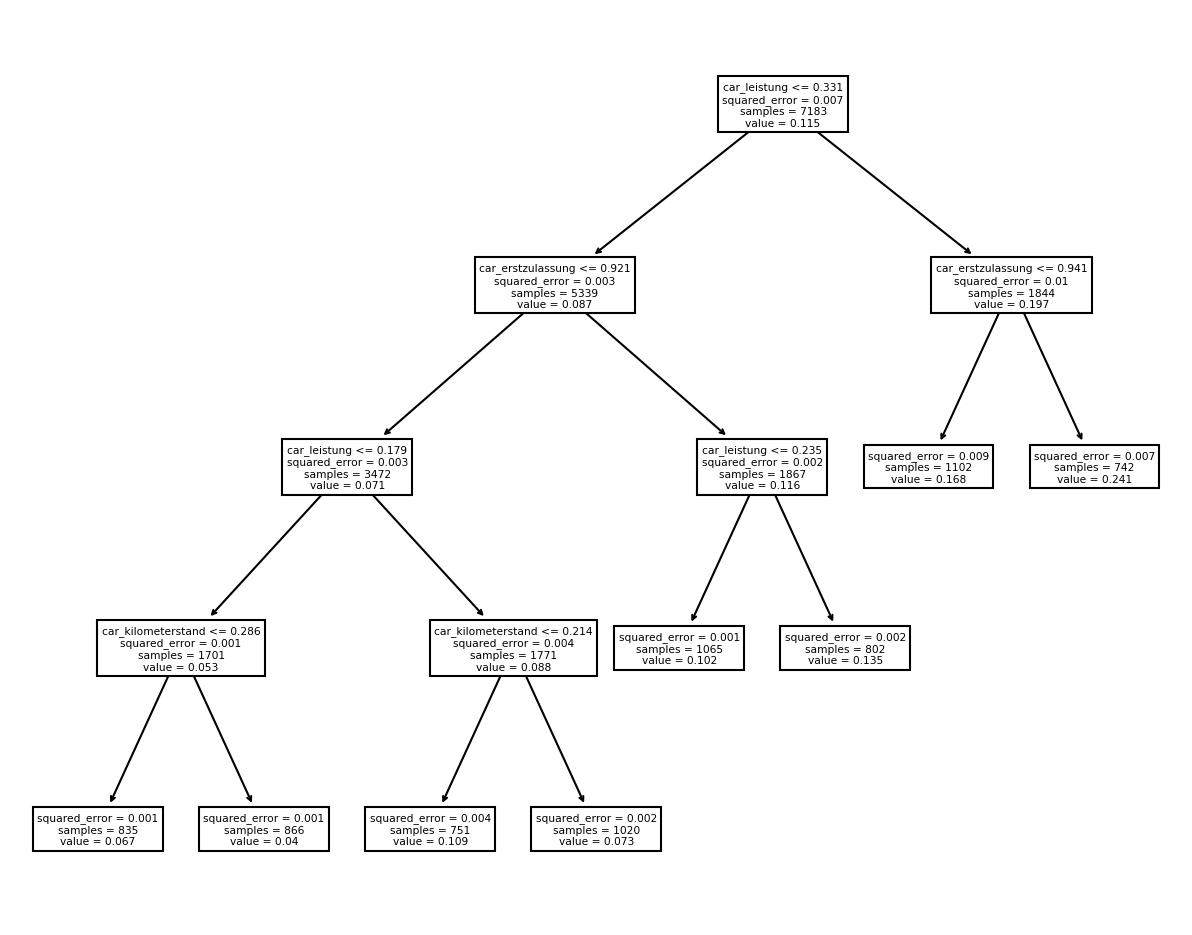

In [93]:

plt.figure(figsize=(10,8), dpi=150)
plot_tree(dt, feature_names=X.columns);